In [1]:
from matplotlib import font_manager
from matplotlib import rcParams
rcParams['font.family'] = 'Helvetica'

In [2]:
import pandas as pd
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

def load_data(filename):
    """Load data from a CSV file."""
    return pd.read_csv(filename, sep='\t')

def filter_by_species_and_year(data, species=None, year=None, comparison='eq'):
    """Filter the data by species and year."""
    if species:
        data = data[data['species'] == species]
    if year:
        if comparison == 'eq':
            data = data[data['year'] == year]
        elif comparison == 'lt':
            data = data[data['year'] <= year]
        elif comparison == 'gt':
            data = data[data['year'] > year]
    return data

def extract_locations(data):
    """Extract and rename latitude and longitude columns."""
    locs = data[['decimalLatitude', 'decimalLongitude']]
    locs.columns = ['lat', 'long']
    locs = locs.dropna(subset=['lat', 'long'])
    return locs

# Dictionary of filenames with species as the key
filenames = {
    'cornuta': 'occurr_csv/0116451-230530130749713.csv',
    'lignaria': 'occurr_csv/0116458-230530130749713.csv',
    'cornifrons': 'occurr_csv/0116466-230530130749713.csv',
    'taurus': 'occurr_csv/0116631-230530130749713.csv'
}

# Load data into dictionary
data = {species: load_data(filename) for species, filename in filenames.items()}

# Apply species filter for lignaria
data['lignaria'] = filter_by_species_and_year(data['lignaria'], species='Osmia lignaria')

# Extract locations for each year
locs_2003 = {species: extract_locations(filter_by_species_and_year(df, year=2003, comparison='lt')) for species, df in data.items()}
locs_2004 = {species: extract_locations(filter_by_species_and_year(df, year=2004, comparison='gt')) for species, df in data.items()}
all_locs = {species: extract_locations(df) for species, df in data.items()}



# Additional filtering
all_locs['cornifrons'] = all_locs['cornifrons'][(all_locs['cornifrons']['long'] > -126) & (all_locs['cornifrons']['long'] < -66)]

# # Drop records
# drops = {
#     'cornuta': [15437, 4838], 
#     'cornifrons': [1109, 1118, 1322, 1889]
# }

# for species, drop_ids in drops.items():
#     all_locs[species] = all_locs[species].drop(drop_ids)

#all_locs['cornuta'] = all_locs['cornuta'][all_locs['cornuta']['long'] < -60]


/tmp/ipykernel_634667/1233097291.py:9: DtypeWarning: Columns (45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filename, sep='\t')
/tmp/ipykernel_634667/1233097291.py:9: DtypeWarning: Columns (39,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filename, sep='\t')


In [34]:
for id, df in locs_2003.items():
    df.to_csv(f'df2csv/{id}_2003.csv', index=False)

In [35]:
for id, df in locs_2004.items():
    df.to_csv(f'df2csv/{id}_2023.csv', index=False)

In [24]:
for id, df in all_locs.items():
    df.to_csv(f'df2csv/{id}_all.csv', index=False)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

lignaria_hex = '#6bdbc9'
colors = [mcolors.to_rgba(lignaria_hex, alpha=i) for i in np.linspace(0.3, 1, 100)]
cmap_lignaria = mcolors.LinearSegmentedColormap.from_list('lignaria', colors)

cornifrons_hex = '#c376f9'
colors = [mcolors.to_rgba(cornifrons_hex, alpha=i) for i in np.linspace(0.3, 1, 100)]
cmap_cornifrons = mcolors.LinearSegmentedColormap.from_list('cornifrons', colors)

taurus_hex = '#ffbe4d'
colors = [mcolors.to_rgba(taurus_hex, alpha=i) for i in np.linspace(0.3, 1, 100)]
cmap_taurus = mcolors.LinearSegmentedColormap.from_list('taurus', colors)

# cornuta_hex = '#6bdbc9'
# colors = [mcolors.to_rgba(cornuta_hex, alpha=i) for i in np.linspace(0.3, 1, 100)]
# cmap_cornuta = mcolors.LinearSegmentedColormap.from_list('cornuta', colors)

great_lakes = cfeature.NaturalEarthFeature(category='physical', name='lakes', scale='110m')



In [5]:
import cartopy.crs as ccrs
import cartopy.feature
import math

def point_in_cell(lat, lon, lat_bounds, lon_bounds):
    return (lat_bounds[0] <= lat <= lat_bounds[1]) and (lon_bounds[0] <= lon <= lon_bounds[1])

def plot_grid_filled_with_points(data_list, colors, species, grid_size=10):
    # Define the latitude and longitude bounds for the map
    lat_min, lat_max = 23, 55
    lon_min, lon_max = -126, -66

    # Constants
    km_per_degree_latitude = 111  # Approximate value
    central_latitude = (lat_max + lat_min) / 2  # Central latitude for longitude calculation
    central_latitude_radians = math.radians(central_latitude)

    # Degree change for 100 km
    degree_change_latitude = grid_size / km_per_degree_latitude
    degree_change_longitude = grid_size / (km_per_degree_latitude * math.cos(central_latitude_radians))

    # Create the base map with cartopy
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])

    # Define the grid size
    lat_bins = np.arange(lat_min, lat_max, degree_change_latitude)
    lon_bins = np.arange(lon_min, lon_max, degree_change_longitude)


    occupied_cells = set()

    for idx, data in enumerate(data_list):
        lats, lons = data['lat'], data['long']
        for i in range(len(lat_bins) - 1):
            for j in range(len(lon_bins) - 1):
                lat_bounds = (lat_bins[i], lat_bins[i+1])
                lon_bounds = (lon_bins[j], lon_bins[j+1])
                points_inside = [point for point in zip(lats, lons) if point_in_cell(point[0], point[1], lat_bounds, lon_bounds)]
                if points_inside:
                    # Add the occupied cell to the set
                    occupied_cells.add((i, j))

                    # Fill the cell on the map
                    ax.fill(
                        [lon_bounds[0], lon_bounds[1], lon_bounds[1], lon_bounds[0]],
                        [lat_bounds[0], lat_bounds[0], lat_bounds[1], lat_bounds[1]],
                        color=colors[idx]
                    )

    ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='gray', linewidth=.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', linewidth=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
    ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')

    ax.add_feature(great_lakes, facecolor='#ededed', linewidth=.3, edgecolor='gray')

    # ax.set_title(f'{species}', x=0.1 , y=-0, color='gray')
    for spine in ax.spines.values():
        spine.set_edgecolor('#bababa')
    
    # labels = ['2004-2023', 'pre-2003']
    # legend_patches = [
    #         mpatches.Patch(color=colors[1], label=labels[1]),  # 'other_species'
    #         mpatches.Patch(color=colors[0], label=labels[0])   # 'lignaria'
    #     ]
    #legend = ax.legend(handles=legend_patches, loc='lower right', borderaxespad=0.)
    # for patch in legend.get_patches():
    #     patch.set_height(10)  
    #     patch.set_width(10)   
    # legend = ax.legend(handles=legend_patches, 
    #     loc=(0.8, 0.17),   
    #     frameon=False,     
    #     handlelength=.8,    
    #     handletextpad=0.5, # Space between patch and text
    #     borderpad=0.5)     # Padding between border and contents (if frameon were True)
    # for text in legend.get_texts():
    #     text.set_color('gray')

    plt.tight_layout()

    aoo = len(occupied_cells) * (grid_size ** 2)
    return aoo

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import math

def point_in_cell(lat, lon, lat_bounds, lon_bounds):
    return (lat_bounds[0] <= lat <= lat_bounds[1]) and (lon_bounds[0] <= lon <= lon_bounds[1])

def calculate_aoo(data_frame, lat_bins, lon_bins, grid_size):
    occupied_cells = set()
    for index, row in data_frame.iterrows():
        lat, lon = row['lat'], row['long']
        for i in range(len(lat_bins) - 1):
            for j in range(len(lon_bins) - 1):
                lat_bounds = (lat_bins[i], lat_bins[i + 1])
                lon_bounds = (lon_bins[j], lon_bins[j + 1])
                if point_in_cell(lat, lon, lat_bounds, lon_bounds):
                    occupied_cells.add((i, j))
    return len(occupied_cells) * (grid_size ** 2)


def calculate_aoo_with_shift(data_list, grid_size=10):
    # Define the latitude and longitude bounds for the map
    lat_min, lat_max = 23, 55
    lon_min, lon_max = -126, -66

    # Constants for degree change calculation
    km_per_degree_latitude = 111  # Approximate value
    central_latitude = (lat_max + lat_min) / 2  # Central latitude for longitude calculation
    central_latitude_radians = math.radians(central_latitude)

    # Degree change for grid size
    degree_change_latitude = grid_size / km_per_degree_latitude
    degree_change_longitude = grid_size / (km_per_degree_latitude * math.cos(central_latitude_radians))

    # Original grid bins
    original_lat_bins = np.arange(lat_min, lat_max, degree_change_latitude)
    original_lon_bins = np.arange(lon_min, lon_max, degree_change_longitude)

    # Calculate original AOO
    aoo_original = calculate_aoo(data_list, original_lat_bins, original_lon_bins, grid_size)

    # Calculate AOO for shifted grids
    shifts = [(0, 0), (0.01, 0), (-0.01, 0), (0, 0.01), (0, -0.01)]  # Example shifts in degrees
    aoo_values = []
    for shift in shifts:
        shifted_lat_bins = np.arange(lat_min + shift[0], lat_max + shift[0], degree_change_latitude)
        shifted_lon_bins = np.arange(lon_min + shift[1], lon_max + shift[1], degree_change_longitude)
        aoo_shifted = calculate_aoo(data_list, shifted_lat_bins, shifted_lon_bins, grid_size)
        aoo_values.append(aoo_shifted)

    # Estimate error
    aoo_error = np.std(aoo_values)

    # Plotting code (omitted for brevity)

    return aoo_original, aoo_error


In [6]:
# aoo_2003, error_2003 = calculate_aoo_with_shift(locs_2003['cornifrons'])
# aoo_2023, error_2023 = calculate_aoo_with_shift(locs_2004['cornifrons'])

In [7]:
# aoo_2003_lig, error_2003_lig = calculate_aoo_with_shift(locs_2003['lignaria'])
# aoo_2023_lig, error_2023_lig = calculate_aoo_with_shift(locs_2004['lignaria'])
# aoo_2003_crta, error_2003_crta = calculate_aoo_with_shift(locs_2003['taurus'])
# aoo_2023_crta, error_2023_crta = calculate_aoo_with_shift(locs_2004['taurus'])

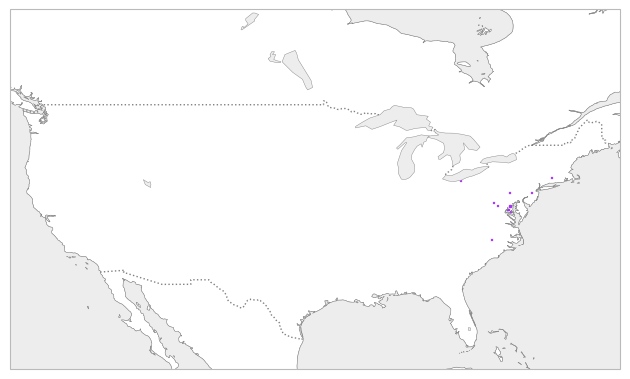

In [8]:
colors = ['#a431f6', '#cb89fa']
data_list = [locs_2003['cornifrons']]
aoo_2003 = plot_grid_filled_with_points(data_list, colors, 'O. cornifrons')
#plt.savefig('figures/dist/cornifrons_dist_swapped.png', format='png', bbox_inches='tight', pad_inches=0)

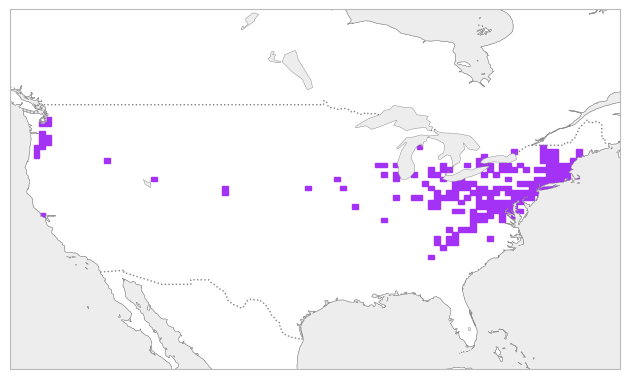

In [22]:
colors = ['#a431f6', '#cb89fa']
data_list = [locs_2004['cornifrons']]
aoo_2004_50 = plot_grid_filled_with_points(data_list, colors, 'O. cornifrons', grid_size=50)
#plt.savefig('figures/dist/cornifrons_dist_swapped.png', format='png', bbox_inches='tight', pad_inches=0)

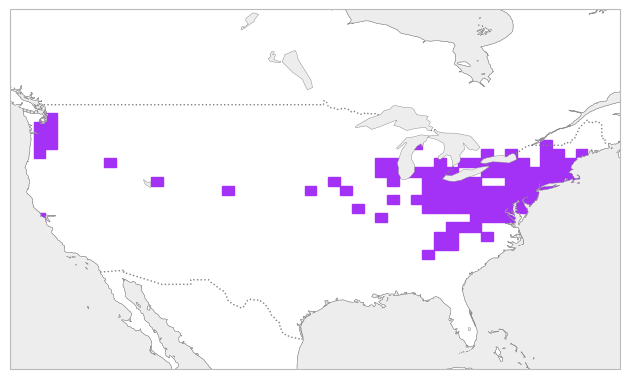

In [23]:
aoo_2004_100 = plot_grid_filled_with_points(data_list, colors, 'O. cornifrons', grid_size=100)

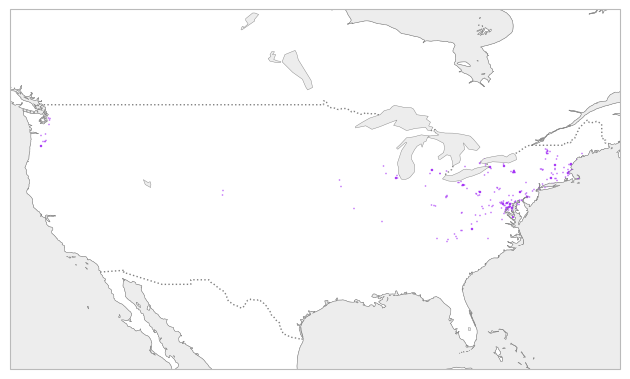

In [27]:
aoo_2004_2 = plot_grid_filled_with_points(data_list, colors, 'O. cornifrons', grid_size=2)

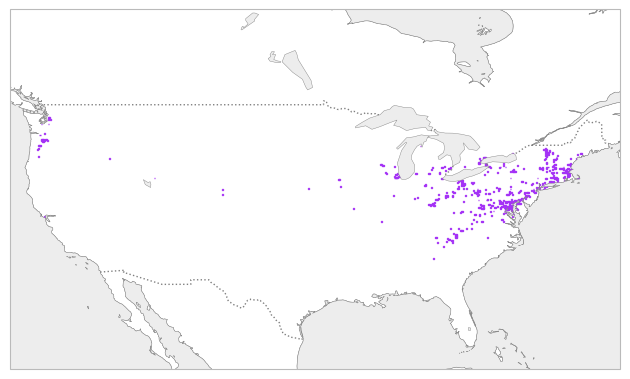

In [25]:
aoo_2004_10 = plot_grid_filled_with_points(data_list, colors, 'O. cornifrons', grid_size=10)

In [28]:
print(aoo_2004_10, aoo_2004_2, aoo_2004_100, aoo_2004_50)

47700 2580 1100000 505000


In [13]:
# time_points = ['2003', '2023']
# aoos = [aoo_2003_crta, aoo_2023_crta]
# errors = [error_2003_crta, error_2023_crta]

# plt.figure(figsize=(2, 4))
# plt.bar(time_points, aoos)
# plt.errorbar(time_points, aoos, yerr=errors, fmt='.', color='black', capsize=10)

# plt.xlabel('Year')
# plt.ylabel('Area of Occupancy (km²)')
# plt.title('AOO Over Time')


In [14]:
# time_points = ['2003', '2023']
# aoos = [aoo_2003, aoo_2004]
# errors = [error_2003, error_2023]

# plt.figure(figsize=(2, 4))
# plt.bar(time_points, aoos)
# plt.errorbar(time_points, aoos, yerr=errors, fmt='.', color='black', capsize=10)

# plt.xlabel('Year')
# plt.ylabel('Area of Occupancy (km²)')
# plt.title('AOO Over Time')


In [13]:
import multiprocessing

def calculate_aoo_wrapper(shift, data_list, lat_min, lat_max, lon_min, lon_max, grid_size):
    # Constants for degree change calculation
    km_per_degree_latitude = 111
    central_latitude = (lat_max + lat_min) / 2
    central_latitude_radians = math.radians(central_latitude)

    # Degree change for grid size
    degree_change_latitude = grid_size / km_per_degree_latitude
    degree_change_longitude = grid_size / (km_per_degree_latitude * math.cos(central_latitude_radians))

    shifted_lat_bins = np.arange(lat_min + shift[0], lat_max + shift[0], degree_change_latitude)
    shifted_lon_bins = np.arange(lon_min + shift[1], lon_max + shift[1], degree_change_longitude)

    return calculate_aoo(data_list, shifted_lat_bins, shifted_lon_bins, grid_size)

def calculate_aoo_with_shift_parallel(data_list, grid_size=10):
    # Define the latitude and longitude bounds for the map
    lat_min, lat_max = 23, 55
    lon_min, lon_max = -126, -66

    # Define shifts
    shifts = [(0, 0), (0.05, 0), (-0.05, 0), (0, 0.05), (0, -0.05)]

    # Create a pool of worker processes
    with multiprocessing.Pool() as pool:
        # Prepare arguments for the wrapper function
        args = [(shift, data_list, lat_min, lat_max, lon_min, lon_max, grid_size) for shift in shifts]

        # Perform parallel processing
        aoo_values = pool.starmap(calculate_aoo_wrapper, args)

    # Calculate original and error
    aoo_original = aoo_values[0]  # Assuming the first shift is (0, 0)
    aoo_error = np.std(aoo_values)

    return aoo_original, aoo_error


In [14]:
orig, err = calculate_aoo_with_shift_parallel(locs_2003['lignaria'])

In [15]:
lig_concat = pd.concat([locs_2003['lignaria'], locs_2004['lignaria']], ignore_index=True)

aoo_2003_cfns, error_2003_cfns = calculate_aoo_with_shift_parallel(locs_2003['cornifrons'])
aoo_2023_cfns, error_2023_cfns = calculate_aoo_with_shift_parallel(locs_2004['cornifrons'])
aoo_2003_lig, error_2003_lig = calculate_aoo_with_shift_parallel(locs_2003['lignaria'])
aoo_2023_lig, error_2023_lig = calculate_aoo_with_shift_parallel(lig_concat)
aoo_2003_taur, error_2003_taur = calculate_aoo_with_shift_parallel(locs_2003['taurus'])
aoo_2023_taur, error_2023_taur = calculate_aoo_with_shift_parallel(locs_2004['taurus'])

In [16]:
aoo_list = [aoo_2003_cfns,
aoo_2023_cfns,
aoo_2003_lig,
aoo_2023_lig,
aoo_2003_taur,
aoo_2023_taur]
error_list = [error_2003_cfns,
error_2023_cfns,
error_2003_lig,
error_2023_lig,
error_2003_taur,
error_2023_taur]



In [21]:
# import json

# data = {
#     "aoo_list": aoo_list,
#     "error_list": error_list
# }

# with open('aoo_data.json', 'w') as file:
#     json.dump(data, file, indent=4)

In [4]:
import json
import os

In [25]:
aoo_data = {}

for json_file in os.listdir('output/'):
    name = json_file[:-5].split('_')[2]+'_'+json_file[:-5].split('_')[3]
    with open(os.path.join('output/',json_file), 'r') as file:
        data = json.load(file)
        aoo_data[name] = {'mean_aoo':data['mean_aoo'],
                          'error':data['std_aoo']}
print(aoo_data)


{'lignaria_2003': {'mean_aoo': 76906.4, 'error': 1064.5933683806227}, 'taurus_all': {'mean_aoo': 32522.8, 'error': 626.4823700631965}, 'cornifrons_all': {'mean_aoo': 37393.6, 'error': 580.1715608335176}, 'cornifrons_2023': {'mean_aoo': 35846.4, 'error': 830.5703100881949}, 'taurus_2023': {'mean_aoo': 32460.6, 'error': 882.9652541295156}, 'lignaria_2023': {'mean_aoo': 42605.2, 'error': 973.8444228931024}, 'taurus_2003': {'mean_aoo': 249.4, 'error': 99.69774320414679}, 'cornifrons_2003': {'mean_aoo': 1114.0, 'error': 140.29967925836468}, 'lignaria_all': {'mean_aoo': 123745.6, 'error': 1403.5101139642704}}


/tmp/ipykernel_634667/3045445213.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{ytick:.0f}' for ytick in new_yticks])
/tmp/ipykernel_634667/3045445213.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{ytick:.0f}' for ytick in new_yticks])
/tmp/ipykernel_634667/3045445213.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{ytick:.0f}' for ytick in new_yticks])


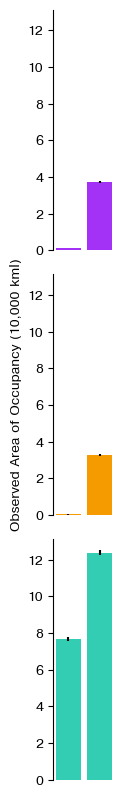

In [28]:

time_points = ['2003', '2023']

fig, axs = plt.subplots(3, 1, figsize=(.8, 10), sharex=True, sharey=True) 

axs[0].bar(time_points, [aoo_data['cornifrons_2003']['mean_aoo'], aoo_data['cornifrons_all']['mean_aoo']], color='#a431f6') 
axs[0].errorbar(time_points, [aoo_data['cornifrons_2003']['mean_aoo'], aoo_data['cornifrons_all']['mean_aoo']], yerr=[aoo_data['cornifrons_2003']['error'], aoo_data['cornifrons_all']['error']], fmt='none', color='black', capsize=0)


axs[1].bar(time_points, [aoo_data['taurus_2003']['mean_aoo'], aoo_data['taurus_all']['mean_aoo']], color='#f59b00')
axs[1].errorbar(time_points, [aoo_data['taurus_2003']['mean_aoo'], aoo_data['taurus_all']['mean_aoo']], yerr=[aoo_data['taurus_2003']['error'], aoo_data['taurus_all']['error']], fmt='none', color='black', capsize=0)  
axs[1].set_ylabel('Observed Area of Occupancy (10,000 km²)')

axs[2].bar(time_points, [aoo_data['lignaria_2003']['mean_aoo'], aoo_data['lignaria_all']['mean_aoo']], color='#32cdb3')
axs[2].errorbar(time_points, [aoo_data['lignaria_2003']['mean_aoo'], aoo_data['lignaria_all']['mean_aoo']], yerr=[aoo_data['lignaria_2003']['error'], aoo_data['lignaria_all']['error']], fmt='none', color='black', capsize=0)  

def set_yticks(ax):
    current_yticks = ax.get_yticks()
    new_yticks = current_yticks / 10000
    ax.set_yticklabels([f'{ytick:.0f}' for ytick in new_yticks])
for ax in axs:
    set_yticks(ax)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    #ax.set_ylim(16)

plt.subplots_adjust(hspace=0.1)
axs[-1].set_xticklabels([], rotation=45)  # Rotate by 45 degrees

# # Adjust the layout
# plt.tight_layout()
plt.savefig('../figures/aoo_barplot.svg', format='svg')

In [7]:


# with open('aoo_data.json', 'r') as file:
#     data = json.load(file)

# # Extract the lists from the data
# aoo_list = data["aoo_list"]
# error_list = data["error_list"]

# aoo_var_names = [
#     'aoo_2003_cfns', 'aoo_2023_cfns', 'aoo_2003_lig', 
#     'aoo_2023_lig', 'aoo_2003_taur', 'aoo_2023_taur'
# ]

# error_var_names = [
#     'error_2003_cfns', 'error_2023_cfns', 'error_2003_lig', 
#     'error_2023_lig', 'error_2003_taur', 'error_2023_taur'
# ]


# for var_name, value in zip(aoo_var_names, aoo_list):
#     globals()[var_name] = value

# for var_name, value in zip(error_var_names, error_list):
#     globals()[var_name] = value

/tmp/ipykernel_8936/2004964997.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{ytick:.0f}' for ytick in new_yticks])
/tmp/ipykernel_8936/2004964997.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{ytick:.0f}' for ytick in new_yticks])
/tmp/ipykernel_8936/2004964997.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{ytick:.0f}' for ytick in new_yticks])


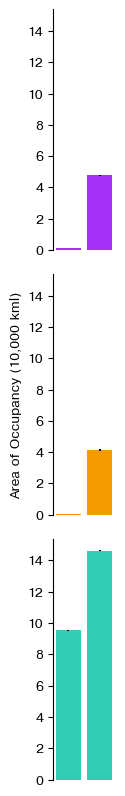

In [12]:

time_points = ['2003', '2023']

fig, axs = plt.subplots(3, 1, figsize=(.8, 10), sharex=True, sharey=True) 

axs[0].bar(time_points, [aoo_2003_cfns, aoo_2023_cfns], color='#a431f6') 
axs[0].errorbar(time_points, [aoo_2003_cfns, aoo_2023_cfns], yerr=[error_2003_cfns, error_2023_cfns], fmt='none', color='black', capsize=0)


axs[1].bar(time_points, [aoo_2003_taur, aoo_2023_taur], color='#f59b00')
axs[1].errorbar(time_points, [aoo_2003_taur, aoo_2023_taur], yerr=[error_2003_taur, error_2023_taur], fmt='none', color='black', capsize=0)  
axs[1].set_ylabel('Area of Occupancy (10,000 km²)')

axs[2].bar(time_points, [aoo_2003_lig, aoo_2023_lig], color='#32cdb3')
axs[2].errorbar(time_points, [aoo_2003_lig, aoo_2023_lig], yerr=[error_2003_lig, error_2023_lig], fmt='none', color='black', capsize=0)  

def set_yticks(ax):
    current_yticks = ax.get_yticks()
    new_yticks = current_yticks / 10000
    ax.set_yticklabels([f'{ytick:.0f}' for ytick in new_yticks])
for ax in axs:
    set_yticks(ax)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    #ax.set_ylim(16)

plt.subplots_adjust(hspace=0.1)
axs[-1].set_xticklabels([], rotation=45)  # Rotate by 45 degrees

# # Adjust the layout
# plt.tight_layout()
# plt.savefig('figures/dist/aoo_plot.svg', format='svg')



In [ ]:

time_points = ['2003', '2023']

fig, axs = plt.subplots(3, 1, figsize=(.8, 10), sharex=True, sharey=True) 

axs[0].bar(time_points, [aoo_2003_cfns, aoo_2023_cfns], color='#a431f6') 
axs[0].errorbar(time_points, [aoo_2003_cfns, aoo_2023_cfns], yerr=[error_2003_cfns, error_2023_cfns], fmt='none', color='black', capsize=6)

axs[1].bar(time_points, [aoo_2003_taur, aoo_2023_taur], color='#f59b00')
axs[1].errorbar(time_points, [aoo_2003_taur, aoo_2023_taur], yerr=[error_2003_taur, error_2023_taur], fmt='none', color='black', capsize=6)  
axs[1].set_ylabel('Area of Occupancy (10,000 km²)')

axs[2].bar(time_points, [aoo_2003_lig, aoo_2023_lig], color='#32cdb3')
axs[2].errorbar(time_points, [aoo_2003_lig, aoo_2023_lig], yerr=[error_2003_lig, error_2023_lig], fmt='none', color='black', capsize=6)  

def set_yticks(ax):
    current_yticks = ax.get_yticks()
    new_yticks = current_yticks / 10000
    ax.set_yticklabels([f'{ytick:.0f}' for ytick in new_yticks])
for ax in axs:
    set_yticks(ax)

plt.subplots_adjust(hspace=0.1)
axs[-1].set_xticklabels(time_points, rotation=45)  # Rotate by 45 degrees


In [20]:
file1 = '/home/mpgetz/repos/bee_mapping/calculate_aoo/df2csv/lignaria_2003.csv'
file2 = '/home/mpgetz/repos/bee_mapping/calculate_aoo/df2csv/lignaria_2023.csv'

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Concatenate the DataFrames
combined_df = pd.concat([df1, df2])

# Export the combined DataFrame to a new CSV file
output_file = 'lignaria_combined.csv'
combined_df.to_csv(output_file, index=False)

,lat,long
0,47.618215,-122.302601
1,42.260889,-70.870778
2,42.260889,-70.870778
3,42.287861,-70.946167
4,42.281694,-70.900167
...,...,...
1525,52.646900,-122.424000
1526,31.321000,-109.256000
1527,33.093828,-96.641450
1528,47.761584,-122.305169
